# Homework 5 Human 5' UTR

## 原论文总结
论文提出一种结合多核糖体分析和深度学习预测人类5' UTR序列对翻译效率影响并设计序列控制蛋白表达的方法。研究构建含28万随机5' UTR序列库，经多核糖体分析和RNA测序测翻译效率，依此训练卷积神经网络模型Optimus 5-Prime预测核糖体负载。模型搭建中，先对5' UTR序列独热编码，再输入含三卷积层和一全连接层的CNN，卷积层提取特征，全连接层映射预测值，经网格搜索定超参数，测试集可解释93% MRL变异。还拓展模型预测多核糖体分布，平均解释83%变异。实验验证10个不同MRL序列预测准确性。结合遗传算法，可设计特定核糖体负载新序列，实现蛋白表达精确控制，还能预测人类5' UTR变体影响，识别疾病相关SNVs，为理解和调控5' UTR序列影响翻译效率提供有力工具。

原论文的模型是一个卷积神经网络。共有三层卷积层，第一层为120卷积核，大小为(8,4)，第二层120卷积核，大小为(8,1)，第三层和第二层结构一致。第四层为全连接层，ReLU激活函数，Dropout=0.3，最后线性变换为一维输出。这个模型的$R^2$可以达到0.93,优于我在本次作业中构建的两种模型。

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import scipy.stats as stats
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import math

## 数据预处理和数据集的准备

In [8]:
def one_hot_encode(df, col='seq', seq_len=50):
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

def r2(x, y):
    x = x.flatten()  # 将 x 转换为一维数组
    y = y.flatten()  # 将 y 转换为一维数组
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2


In [9]:
class UTRDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = np.array(labels).reshape(-1,1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_data = one_hot_encode(train)
test_data = one_hot_encode(test)
train_dataset,validation_dataset = torch.utils.data.random_split(UTRDataset(train_data,train['label']),[int(len(train_data)*0.8),int(len(train_data)*0.2)])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_dataset = UTRDataset(test_data, test['label'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Transformer模型

Transformer模型是一种基于注意力机制的深度学习模型。与传统的RNN不同，Transformer模型不依赖于序列的顺序处理，而是通过自注意力机制（Self-Attention）来捕捉序列中各个位置之间的依赖关系。Transformer模型由编码器（Encoder）和解码器（Decoder）组成，编码器负责将输入序列转换为隐藏表示，解码器则将隐藏表示转换为输出序列。由于其并行计算能力和捕捉长距离依赖关系的优势，Transformer模型在自然语言处理等领域取得了显著的成功。但在这里，我使用了Encoder-only的模型变体，节约计算资源。

In [16]:
class MultiHeadAttnention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttnention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(attn, dim=-1)
        attn = torch.matmul(attn, V)
        return attn
    def split_heads(self, x):
        x = x.view(x.size(0), -1, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    def combine_heads(self, x):
        x = x.transpose(1, 2)
        x = x.contiguous().view(x.size(0), -1, self.d_model)
        return x
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn = self.scaled_dot_product_attention(Q, K, V, mask)
        attn = self.combine_heads(attn)
        return self.W_o(attn)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [17]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_size):
        super(EncoderBlock, self).__init__()
        self.attn = MultiHeadAttnention(d_model, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_hidden_size),
            nn.ReLU(),
            nn.Linear(ff_hidden_size, d_model)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        x = x + self.attn(x, x, x, mask)
        x = self.ln1(x)
        x = x + self.ff(x)
        x = self.ln2(x)
        return x

class Encode(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_size, num_layers):
        super(Encode, self).__init__()
        self.blocks = nn.ModuleList([EncoderBlock(d_model, num_heads, ff_hidden_size) for _ in range(num_layers)])
        self.fc = nn.Sequential(
            nn.Linear(50 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x, mask=None):
        for block in self.blocks:
            x = block(x, mask)
        x = x.view(x.size(0), -1)
        return self.fc(x)

Epoch [1/10], Loss: 0.9269
Epoch [1/10], Loss: 0.6273
Epoch [2/10], Loss: 0.6922
Epoch [2/10], Loss: 0.3149
Epoch [3/10], Loss: 0.4692
Epoch [3/10], Loss: 0.3745
Epoch [4/10], Loss: 0.3236
Epoch [4/10], Loss: 0.2893
Epoch [5/10], Loss: 0.2222
Epoch [5/10], Loss: 0.2837
Epoch [6/10], Loss: 0.2008
Epoch [6/10], Loss: 0.2777
Epoch [7/10], Loss: 0.2666
Epoch [7/10], Loss: 0.3262
Epoch [8/10], Loss: 0.2499
Epoch [8/10], Loss: 0.2656
Epoch [9/10], Loss: 0.4002
Epoch [9/10], Loss: 0.2989
Epoch [10/10], Loss: 0.3330
Epoch [10/10], Loss: 0.2658


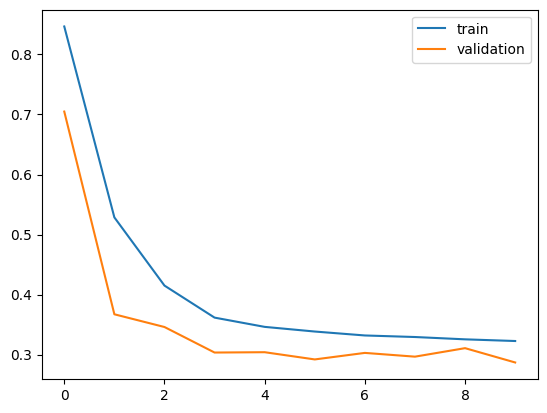

In [19]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
embed_size = 4
num_layers = 8
heads = 1
forward_expansion = 4
dropout = 0.1
max_length = 50
learning_rate = 0.001
num_epochs = 10

# Initialize network
model = Encode(
    d_model=embed_size,
    num_heads=heads,
    ff_hidden_size=embed_size*forward_expansion,
    num_layers=num_layers
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_r2 = 0
    for data, labels in train_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()

        # Forward pass
        outputs = model(data, None)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(total_loss/len(train_loader))

    total_loss = 0
    total_r2 = 0
    model.eval()
    for data, labels in validation_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()
        outputs = model(data, None)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    val_losses.append(total_loss/len(validation_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train','validation'])
plt.show()

In [21]:
all_labels = []
all_outputs = []
model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()
        outputs = model(data, None)
        all_labels.extend(labels.cpu().detach().numpy())
        all_outputs.extend(outputs.squeeze().cpu().detach().numpy())

total_r2 = r2(np.array(all_labels), np.array(all_outputs))
print(f'Test R^2: {total_r2:.4f}')

Test R^2: 0.7831


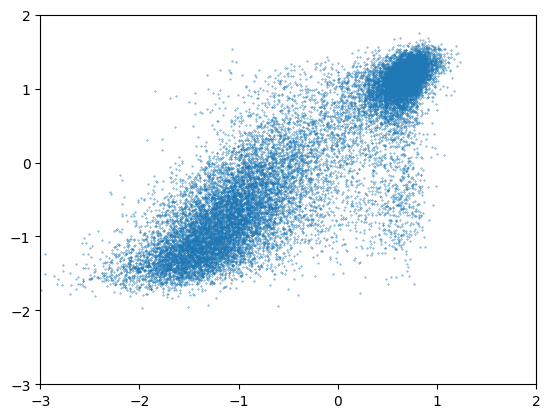

In [ ]:
plt.xlim(-3,2)
plt.ylim(-3,2)
plt.scatter(all_outputs,all_labels,s=0.1)

整体预测的效果一般，部分结果预测偏差较大，大部分结果预测都略偏小

## CNN模型
1D-CNN通过在一维上的卷积操作，提取特征，获得句子的特征表示，其可能更倾向于某种特征匹配，而不能很好关注长距离的语言关系，在现代的自然语言模型中使用较少。

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, 3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*12, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.pool = nn.MaxPool1d(2, 2)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Epoch [1/10], Loss: 0.1549
Epoch [1/10], Loss: 0.3017
Epoch [2/10], Loss: 0.1069
Epoch [2/10], Loss: 0.1703
Epoch [3/10], Loss: 0.1538
Epoch [3/10], Loss: 0.1241
Epoch [4/10], Loss: 0.0837
Epoch [4/10], Loss: 0.1239
Epoch [5/10], Loss: 0.0766
Epoch [5/10], Loss: 0.0866
Epoch [6/10], Loss: 0.1991
Epoch [6/10], Loss: 0.0623
Epoch [7/10], Loss: 0.1594
Epoch [7/10], Loss: 0.0867
Epoch [8/10], Loss: 0.0838
Epoch [8/10], Loss: 0.0878
Epoch [9/10], Loss: 0.0652
Epoch [9/10], Loss: 0.0767
Epoch [10/10], Loss: 0.0530
Epoch [10/10], Loss: 0.1011


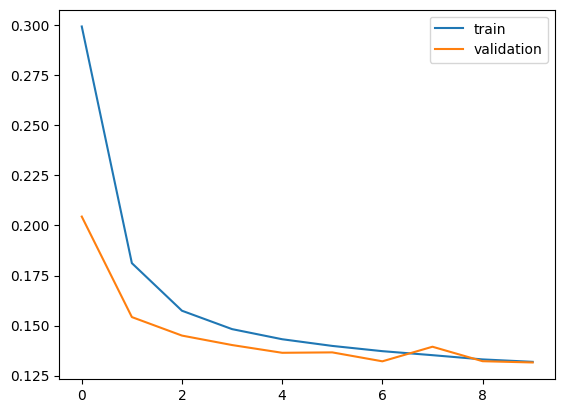

Test R^2: 0.9207


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_r2 = 0
    for data, labels in train_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(total_loss/len(train_loader))

    total_loss = 0
    total_r2 = 0
    model.eval()
    for data, labels in validation_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()
        outputs = model(data)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    val_losses.append(total_loss/len(validation_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}') 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train','validation'])
plt.show()

all_labels = []
all_outputs = []
model.eval()

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()
        outputs = model(data)
        all_labels.extend(labels.cpu().detach().numpy())
        all_outputs.extend(outputs.squeeze().cpu().detach().numpy())
total_r2 = r2(np.array(all_labels), np.array(all_outputs))
print(f'Test R^2: {total_r2:.4f}')

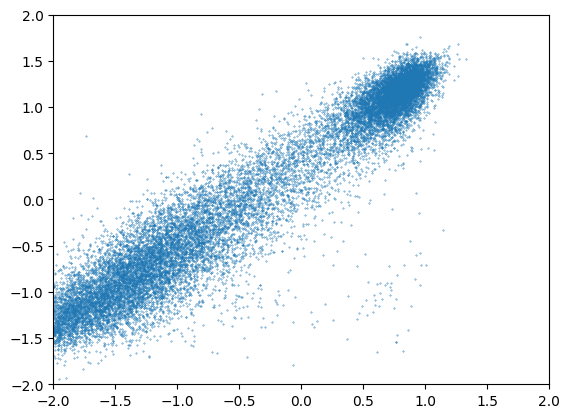

In [27]:
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.scatter(all_outputs,all_labels,s=0.1)

效果相较于transformer好得多，由此可见，在小规模数据低参数量时，transformer可能并非最佳选择

## LSTM
LSTM是一种特殊的RNN，能够捕捉长时间依赖关系。通过引入遗忘门、输入门和输出门，LSTM有效解决了传统RNN的梯度消失问题，适用于处理序列数据。
这里就不手写lstm了，直接调用pytorch提供的lstm.取最后一个时间步对应的输出作为最后分类的输入。

In [28]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(4, 64, 2, batch_first=True)
        self.fc1 = nn.Linear(50*64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.contiguous().view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Epoch [1/5], Loss: 0.1013
Epoch [1/5], Loss: 0.2340
Epoch [2/5], Loss: 0.0908
Epoch [2/5], Loss: 0.0746
Epoch [3/5], Loss: 0.1332
Epoch [3/5], Loss: 0.0503
Epoch [4/5], Loss: 0.0763
Epoch [4/5], Loss: 0.0416
Epoch [5/5], Loss: 0.3769
Epoch [5/5], Loss: 0.0444


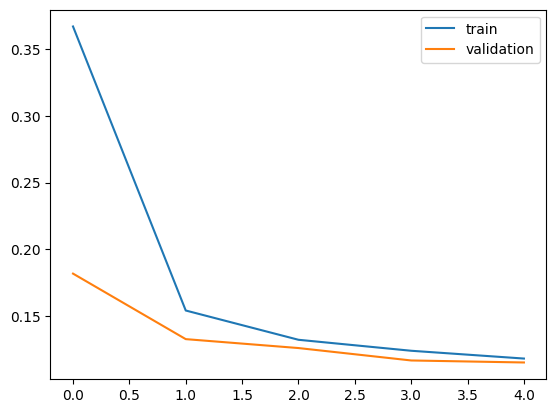

Test R^2: 0.9346


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_r2 = 0
    for data, labels in train_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(total_loss/len(train_loader))

    total_loss = 0
    total_r2 = 0
    model.eval()
    for data, labels in validation_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()
        outputs = model(data)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    val_losses.append(total_loss/len(validation_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}') 
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train','validation'])
plt.show()

all_labels = []
all_outputs = []
model.eval()

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device).float()
        labels = labels.to(device).float()
        outputs = model(data)
        all_labels.extend(labels.cpu().detach().numpy())
        all_outputs.extend(outputs.squeeze().cpu().detach().numpy())
total_r2 = r2(np.array(all_labels), np.array(all_outputs))
print(f'Test R^2: {total_r2:.4f}')

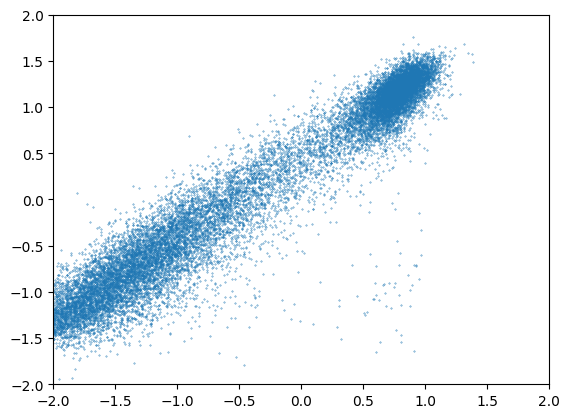

In [31]:
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.scatter(all_outputs,all_labels,s=0.1)

完全符合预期的是，LSTM的预测效果确实好于CNN,这是因为LSTM可以充分利用序列的顺序信息，从而能够更好预测序列所对应的变量值。